In [1]:
%matplotlib inline
import numpy as np
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
from plot_colorbar import colorbar
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
data = loadmat('AVISO_ssh_reference_qd_20081105.mat')
print(data.keys())

ssh = data['ssh']
lons = np.squeeze(data['longitudes'])
lats = np.squeeze(data['latitudes'])
print('ssh shape is ',ssh.shape)

# Convert ssh from cm to m
ssh = ssh/100

dict_keys(['__header__', '__version__', '__globals__', 'latitudes', 'longitudes', 'ssh'])
ssh shape is  (721, 1440)


## Plot the snapshot of ssh

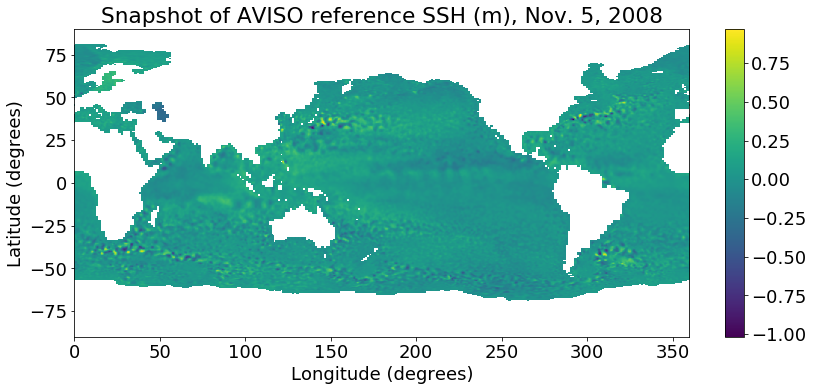

In [3]:
# Set the default fontsize
font = {'size'   : 18}
matplotlib.rc('font', **font)

plt.figure(figsize=(12,8))
im = plt.imshow(ssh,origin='lower',extent=[lons[0],lons[-1],lats[0],lats[-1]]) 
plt.title('Snapshot of AVISO reference SSH (m), Nov. 5, 2008')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
colorbar(im)
plt.savefig('altimeterssh.png')

## Compute velocities for this snapshot

In [4]:
# Create a padded array to take derivatives using centered differences)
# Concatenate columns to allow for periodic boundary condition in longitude
ssh_col_padded = np.hstack((ssh[:,-1:],ssh[:,:],ssh[:,0:1]))
# Add extra rows of nans at top and bottom
ssh_row_padded = np.vstack((np.full(ssh.shape[1],np.nan),ssh[:,:],np.full(ssh.shape[1],np.nan)))

# Take centered differences
diffy = ssh_row_padded[2:,:] - ssh_row_padded[:-2,:]
diffx = ssh_col_padded[:,2:] - ssh_col_padded[:,:-2]
print('diffy and diffx shapes are ',diffy.shape,diffx.shape)

# Compute f arrays
f = 2*2*np.pi*(1/86164) * np.sin(np.deg2rad(lats)) # by default this is defined as a row vector
f.shape = (f.shape[0],1) # redefine as a column vector
f = np.broadcast_to(f,(ssh.shape[0],ssh.shape[1])) # repeat the column vector for the number of columns in ssh
print('f shape is ',f.shape)

# Compute value of dy, the grid spacing in the north-south direction
# The calculation below is for a grid spacing of 0.25 degrees, the grid spacing of this AVISO dataset

gridspacing = 0.25
dy = (gridspacing/360)*2*np.pi*6371000  

# Compute array of dx values, where dx is the grid spacing in the east-west direction, which changes with 
# cos(latitude) on a latitude-longitude grid
# Again, this is written for a grid spacing of 0.25 degrees, the spacing on the AVISO grid. 

dx = (gridspacing/360)*2*np.pi*6371000 * np.cos(np.deg2rad(lats))
dx.shape = (dx.shape[0],1)
dx = np.broadcast_to(dx,(ssh.shape[0],ssh.shape[1]))
print('dx shape is ',dx.shape)

# Compute u, the east-west velocity

g = 9.8 # m/s^2
u = - g*(1/(2*dy))*(diffy)/f

# Compute v, the north-south velocity:

v = g*diffx/(2*f*dx)

# Set the values of v at the poles to be nan:
v[1,:] = np.nan
v[-1,:] = np.nan

# Find the indices with latitudes between -5 and +5 degrees, and 
# force the values here to be NaN

index = np.where(abs(lats)<5)
u[index,:] = np.nan
v[index,:] = np.nan

# Set u and v to be nan whenever one of them is nan:

index = np.where(np.isnan(u*v))
u[index]= np.nan
v[index]= np.nan

# Compute rms speed--square root of sum of squares of velocity components
speed = np.sqrt(u**2 + v**2)

diffy and diffx shapes are  (721, 1440) (721, 1440)
f shape is  (721, 1440)
dx shape is  (721, 1440)


## Plot speed

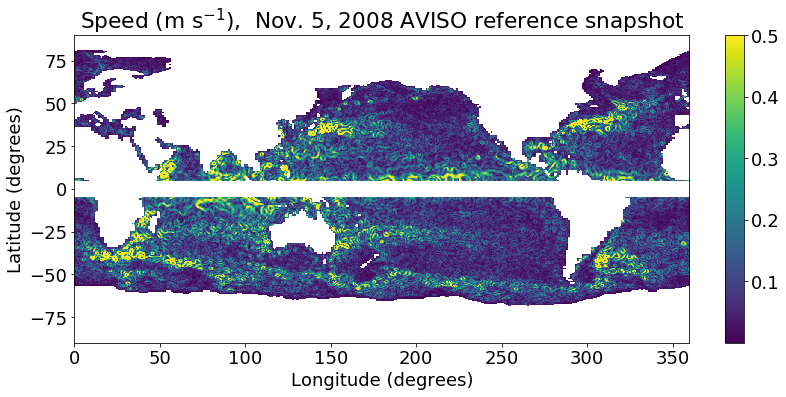

In [5]:
plt.figure(figsize=(12,8))
im = plt.imshow(speed,origin='lower',extent=[lons[0],lons[-1],lats[0],lats[-1]],vmax=0.5)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Speed (m s$^{-1}$),  Nov. 5, 2008 AVISO reference snapshot')
colorbar(im)

plt.savefig('altimeterspeeds.png')

## Plot u and v along 30 degrees North

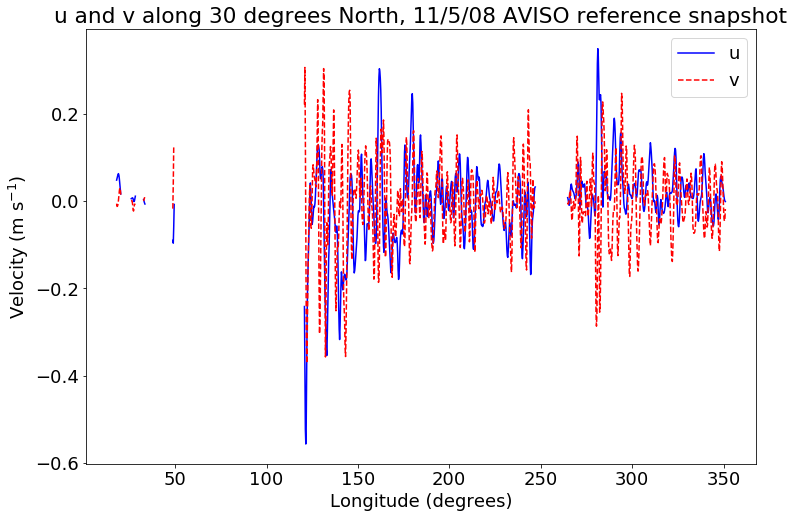

In [6]:
plt.figure(figsize=(12,8))
plt.plot(lons,np.squeeze(u[lats==30,:]),'b-',label='u')
plt.plot(lons,np.squeeze(v[lats==30,:]),'r--',label='v')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Velocity (m s$^{-1}$)')
plt.title('u and v along 30 degrees North, 11/5/08 AVISO reference snapshot')
plt.legend()

plt.savefig('altimetervelocities_30North.png')